## Loading Packages and Creating Functions

In [1]:
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
%matplotlib inline
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons,make_circles
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

/Users/connormccambridge/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Creating Data

In [3]:
X, Y = make_moons(noise=0.25, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

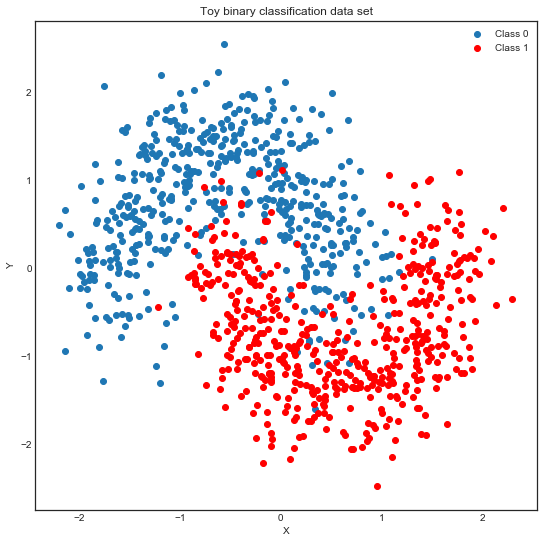

In [4]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

## Basic Logistic Classifier

In [5]:
%%time
lr = LogisticRegression()
lr = lr.fit(X_train, Y_train)

CPU times: user 2.79 ms, sys: 2.39 ms, total: 5.18 ms
Wall time: 9.85 ms


In [6]:
pred_lr = lr.predict(X_test)
print('Logistic Regression Accuracy = {}%'.format((Y_test == pred_lr).mean() * 100))

Logistic Regression Accuracy = 88.6%


## Neural Network Model Function

In [1]:
 def construct_nn(ann_input, ann_output, n_hidden):
 
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden)
    init_2 = np.random.randn(n_hidden, n_hidden)
    init_out = np.random.randn(n_hidden)

    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(theano.tensor.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(theano.tensor.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(theano.tensor.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0]
                          )
    return neural_network

## Neural Network with 2-5 Node Hidden Layers

In [8]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

In [9]:
nn_5 = construct_nn(ann_input, ann_output,5)

### Neural Network Diagram

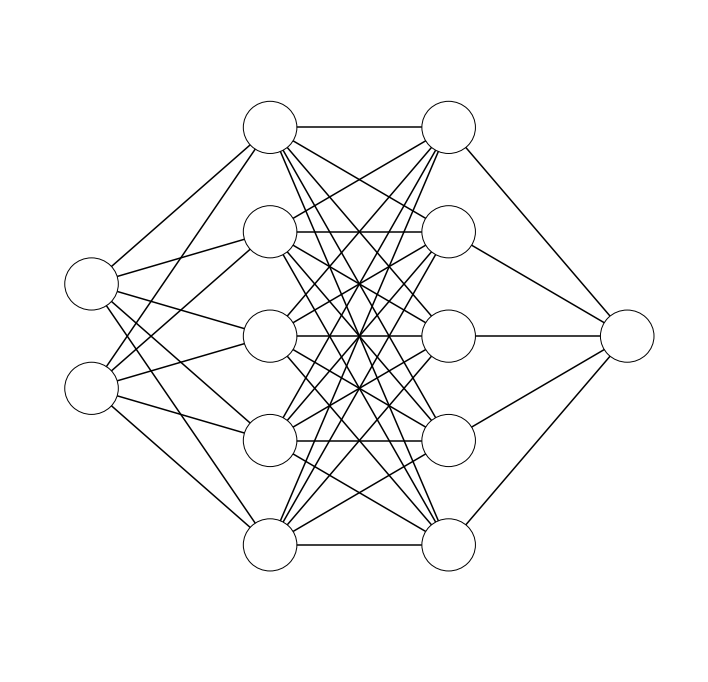

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [2, 5, 5, 1])
#fig.savefig('nn.png')

### Sampling

In [11]:
%%time
with nn_5:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace_metr_5 = pm.sample(5000, step, start=start)

logp = -149.64, ||grad|| = 0.26138: 100%|██████████| 539/539 [00:00<00:00, 1030.22it/s] 
100%|██████████| 5500/5500 [00:05<00:00, 1087.95it/s]

CPU times: user 8.79 s, sys: 498 ms, total: 9.29 s
Wall time: 12.4 s


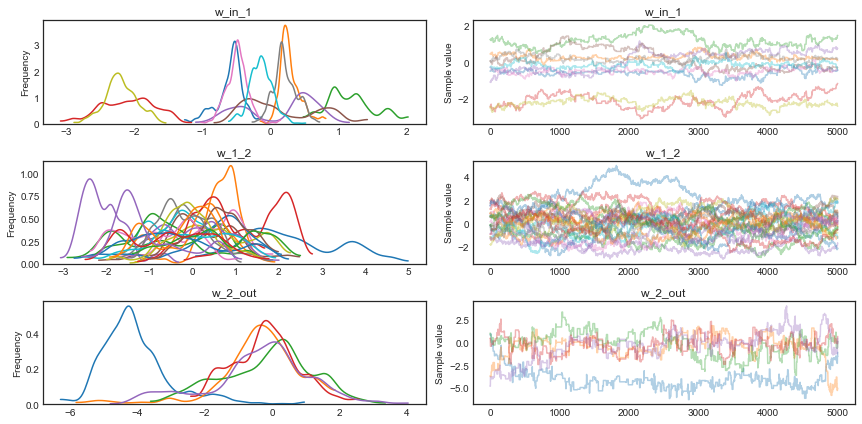

In [12]:
pm.traceplot(trace_metr_5);

In [13]:
%%time
with nn_5:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_nuts_5 = pm.sample(5000, step, start=start)

logp = -149.64, ||grad|| = 0.26138: 100%|██████████| 539/539 [00:00<00:00, 719.23it/s]  
100%|██████████| 5500/5500 [06:02<00:00, 15.19it/s]

CPU times: user 11min 50s, sys: 5.68 s, total: 11min 56s
Wall time: 6min 5s


/Users/connormccambridge/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 100 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



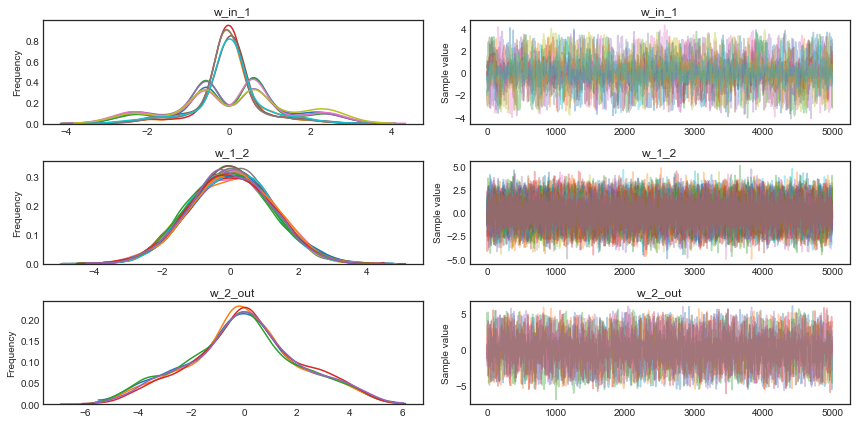

In [14]:
pm.traceplot(trace_nuts_5);

In [15]:
%%time
with nn_5:
    v_params = pm.variational.advi(n=50000)
    trace_advi_5 = pm.variational.sample_vp(v_params, draws=5000)

/Users/connormccambridge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  
Average ELBO = -180.28: 100%|██████████| 50000/50000 [00:12<00:00, 3966.64it/s]
Finished [100%]: Average ELBO = -172.13
/Users/connormccambridge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 5000/5000 [00:00<00:00, 12802.65it/s]

CPU times: user 26.4 s, sys: 529 ms, total: 26.9 s
Wall time: 18.4 s


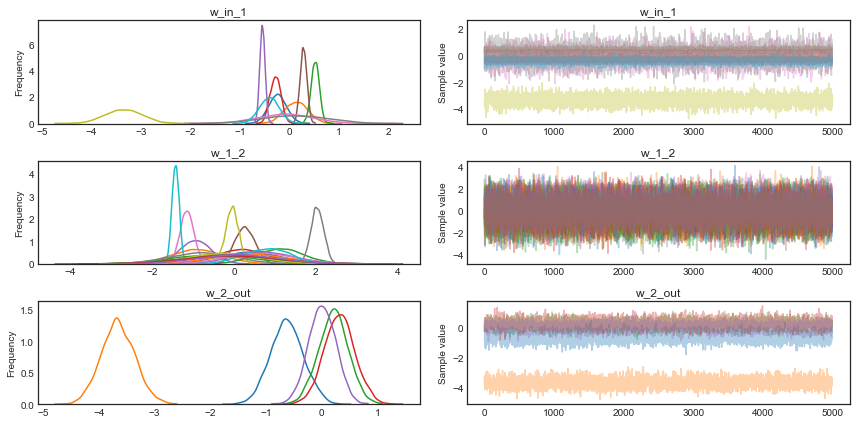

In [16]:
pm.traceplot(trace_advi_5);

In [17]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

In [18]:
# Creater posterior predictive samples
ppc_metr_5 = pm.sample_ppc(trace_metr_5, model=nn_5, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred_metr_5 = ppc_metr_5['out'].mean(axis=0) > 0.5

print('Metropolis Neural Network [5,5] Accuracy = {}%'.format((Y_test == pred_metr_5).mean() * 100))

100%|██████████| 500/500 [00:00<00:00, 1147.17it/s]

Metropolis Neural Network [5,5] Accuracy = 94.19999999999999%


In [19]:
# Creater posterior predictive samples
ppc_nuts_5 = pm.sample_ppc(trace_nuts_5, model=nn_5, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred_nuts_5 = ppc_nuts_5['out'].mean(axis=0) > 0.5

print('NUTS Neural Network [5,5] Accuracy = {}%'.format((Y_test == pred_nuts_5).mean() * 100))

100%|██████████| 500/500 [00:00<00:00, 2114.60it/s]

NUTS Neural Network [5,5] Accuracy = 94.19999999999999%


In [20]:
# Creater posterior predictive samples
ppc_advi_5 = pm.sample_ppc(trace_advi_5, model=nn_5, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred_advi_5 = ppc_advi_5['out'].mean(axis=0) > 0.5


print('ADVI Neural Network [5,5] Accuracy = {}%'.format((Y_test == pred_advi_5).mean() * 100))

100%|██████████| 500/500 [00:00<00:00, 2174.97it/s]

ADVI Neural Network [5,5] Accuracy = 94.39999999999999%


All three different Bayesian neural network models did a much better job at predicting the classification of the new testing set, but all the of the accuracy of the neural networks were very close to one another, with the first models performing exactly the same 94.2% with the ADVI model performin a little better with 94.4% accuracy.

### Scatter Plots

Lets see exactly what the models predicted of the testing data provided to them by plotting their predictions

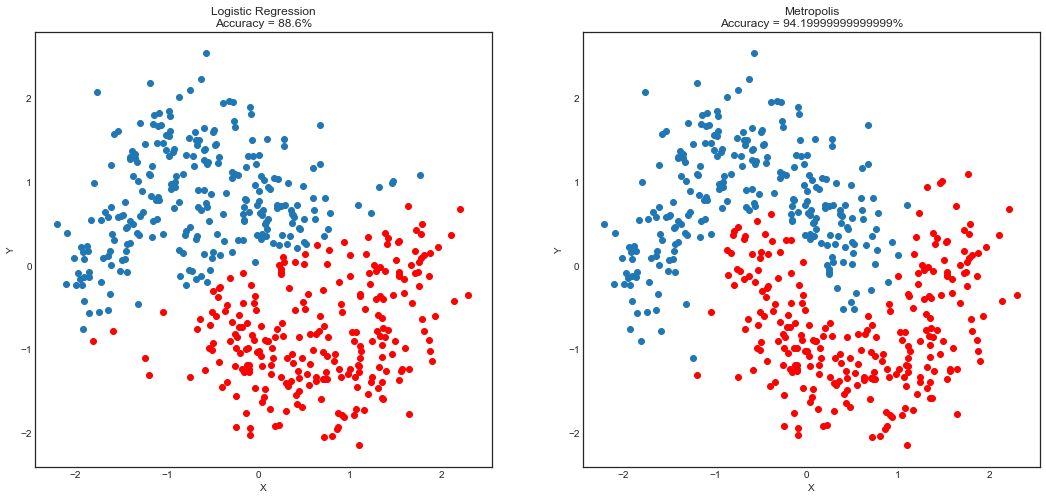

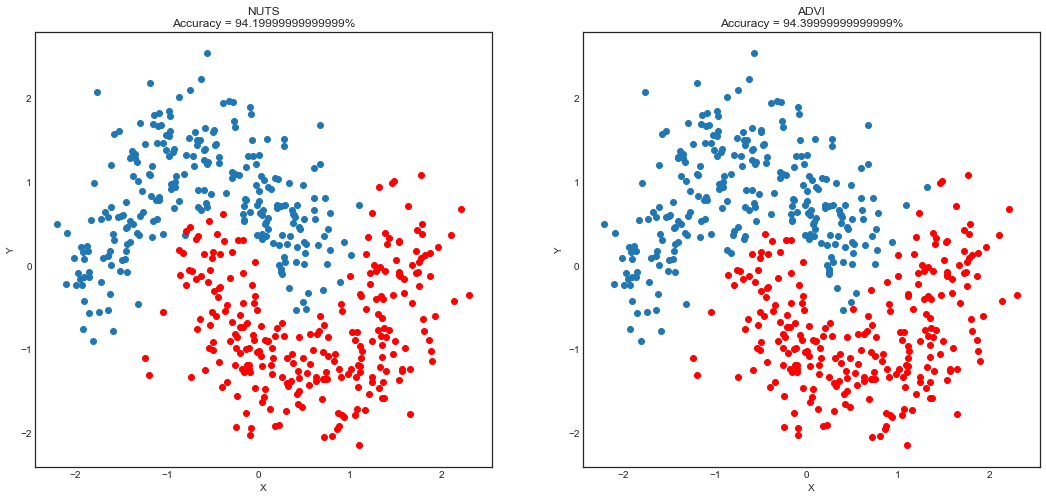

In [22]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18, 8));
fig,(ax3,ax4) = plt.subplots(1,2,figsize=(18, 8));
ax1.scatter(X_test[pred_lr==0, 0], X_test[pred_lr==0, 1])
ax1.scatter(X_test[pred_lr==1, 0], X_test[pred_lr==1, 1], color='r')
ax1.set(title='Logistic Regression\nAccuracy = {}%'.format((Y_test == pred_lr).mean() * 100), xlabel='X', ylabel='Y');
ax2.scatter(X_test[pred_metr_5==0, 0], X_test[pred_metr_5==0, 1])
ax2.scatter(X_test[pred_metr_5==1, 0], X_test[pred_metr_5==1, 1], color='r')
ax2.set(title='Metropolis\nAccuracy = {}%'.format((Y_test == pred_metr_5).mean() * 100), xlabel='X', ylabel='Y');
ax3.scatter(X_test[pred_nuts_5==0, 0], X_test[pred_nuts_5==0, 1])
ax3.scatter(X_test[pred_nuts_5==1, 0], X_test[pred_nuts_5==1, 1], color='r')
ax3.set(title='NUTS\nAccuracy = {}%'.format((Y_test == pred_nuts_5).mean() * 100), xlabel='X', ylabel='Y');
ax4.scatter(X_test[pred_advi_5==0, 0], X_test[pred_advi_5==0, 1])
ax4.scatter(X_test[pred_advi_5==1, 0], X_test[pred_advi_5==1, 1], color='r')
ax4.set(title='ADVI\nAccuracy = {}%'.format((Y_test == pred_advi_5).mean() * 100), xlabel='X', ylabel='Y');

In looking at the scatter plot created it is easy to see where the logistic regression just gave it its best try with a single straight line where the neural networks were able to go between the two different moons that were created or a greater overall accuracy of the model. It is really interesting that these two kinds of models can so much of different decisions using these simple datapoints.

### Probability surface

Lets now take it one step further by ploting not only the predicted results but the underlying probability of the models that led to those results. To do this we will plot the whole class probability predictions on a grid over the input space.

In [23]:
h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = lr.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

In [24]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [25]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

ppc_metr_5 = pm.sample_ppc(trace_metr_5, model=nn_5, samples=500)
ppc_nuts_5 = pm.sample_ppc(trace_nuts_5, model=nn_5, samples=500)
ppc_advi_5 = pm.sample_ppc(trace_advi_5, model=nn_5, samples=500)

100%|██████████| 500/500 [00:01<00:00, 450.00it/s]


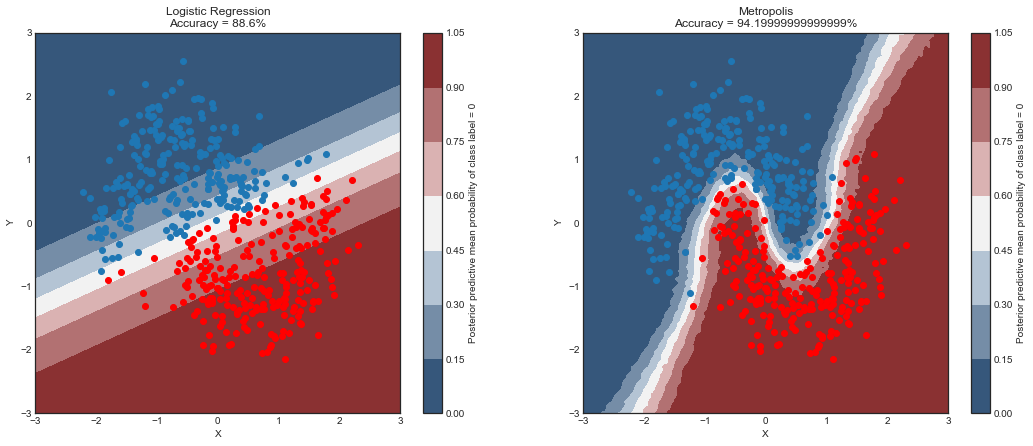

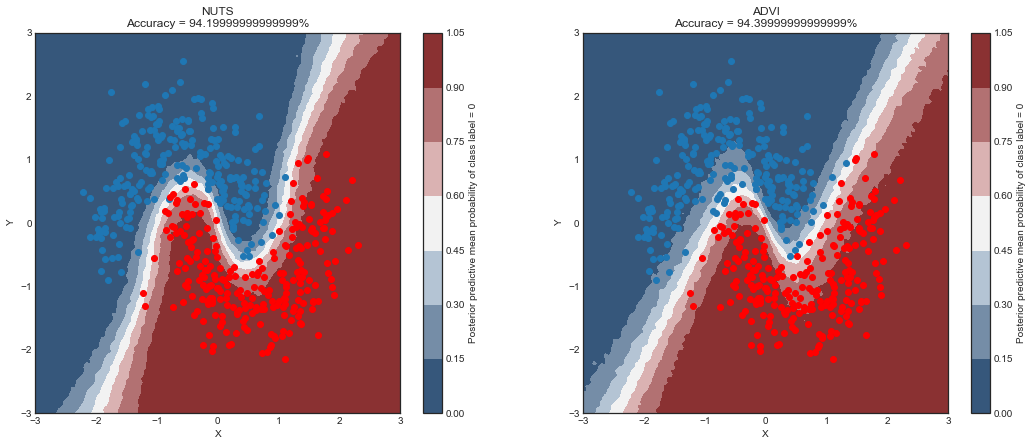

In [26]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(18, 7));
fig,(ax3,ax4) = plt.subplots(1,2,figsize=(18, 7));
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
contour = ax1.contourf(xx, yy, Z, cmap=cmap, )
ax1.scatter(X_test[pred_lr==0, 0], X_test[pred_lr==0, 1])
ax1.scatter(X_test[pred_lr==1, 0], X_test[pred_lr==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax1)
_ = ax1.set(title='Logistic Regression\nAccuracy = {}%'.format((Y_test == pred_lr).mean() * 100) ,xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

contour = ax2.contourf(*grid, ppc_metr_5['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax2.scatter(X_test[pred_metr_5==0, 0], X_test[pred_metr_5==0, 1])
ax2.scatter(X_test[pred_metr_5==1, 0], X_test[pred_metr_5==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax2)
_ = ax2.set(title='Metropolis\nAccuracy = {}%'.format((Y_test == pred_metr_5).mean() * 100) ,xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

contour = ax3.contourf(*grid, ppc_nuts_5['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax3.scatter(X_test[pred_nuts_5==0, 0], X_test[pred_nuts_5==0, 1])
ax3.scatter(X_test[pred_nuts_5==1, 0], X_test[pred_nuts_5==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax3)
_ = ax3.set(title='NUTS\nAccuracy = {}%'.format((Y_test == pred_nuts_5).mean() * 100), xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

contour = ax4.contourf(*grid, ppc_advi_5['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax4.scatter(X_test[pred_advi_5==0, 0], X_test[pred_advi_5==0, 1])
ax4.scatter(X_test[pred_advi_5==1, 0], X_test[pred_advi_5==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax4)
_ = ax4.set(title='ADVI\nAccuracy = {}%'.format((Y_test == pred_advi_5).mean() * 100), xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');



## Results

| Model      | Step Method | Hidden Layes| Time to Build | Accuracy|
| :-------: | :----:| :-------: | :----:| :----:|
| Logistic Regression | - | - |9.85 ms|88.6%|
| BNN | Metropolis | 5,5 |12.4 s|94.2%|
| BNN | NUTS | 5,5 |6min 5s|94.2%|
| BNN | ADVI | 5,5 |18.4 s|94.4%|